In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [7]:
(r_train, r_valid, r_test), info = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:]','test'],
    shuffle_files=True,
    with_info=True
)

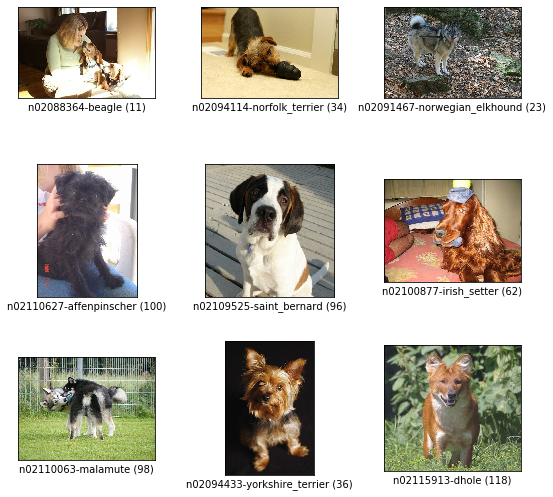

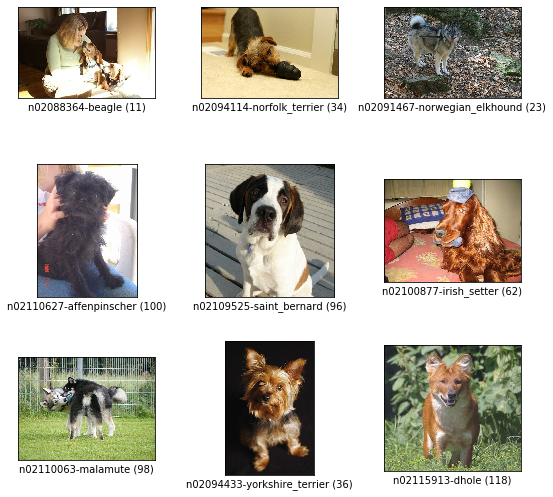

In [8]:
tfds.show_examples(r_train, info)

In [6]:
INPUT_SHAPE = (224,224,3)
BATCH_SIZE = 32
num_classes = info.features['label'].num_classes

NameError: name 'info' is not defined

In [5]:
# 전처리
def normalize_and_resize_img(data):
    image=tf.image.resize(data['image'], [INPUT_SHAPE[0],INPUT_SHAPE[1]])
    data['image']=tf.cast(image, tf.float32)/255.
    return data['image'], data['label']

def apply_map_on_dataset(ds, is_test=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(BATCH_SIZE)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
train = apply_map_on_dataset(r_train)
valid = apply_map_on_dataset(r_valid)
test = apply_map_on_dataset(r_test, True)

In [7]:
vgg16_model = tf.keras.applications.VGG16(include_top=False,
                                          input_shape=INPUT_SHAPE,
                                          weights='imagenet'
                                        )
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
x = vgg16_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

vgg16_dog = tf.keras.models.Model([vgg16_model.input], [x])
vgg16_dog.summary() # shape이 맞지 않는다면 모델 summary를 꼭 확인해보자

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
vgg16_dog.compile(loss='sparse_categorical_crossentropy',
                optimizer='SGD',
                metrics=['accuracy']
                )

In [13]:
history = vgg16_dog.fit(train,
                        steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
                        validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
                        epochs=20,
                        validation_data=valid,
                        verbose=1,
                        use_multiprocessing=True,
                       )

Epoch 1/20
300/300 [==============================] - 118s 393ms/step - loss: 4.7967 - accuracy: 0.0095 - val_loss: 4.7856 - val_accuracy: 0.0096
Epoch 2/20
300/300 [==============================] - 109s 362ms/step - loss: 4.7728 - accuracy: 0.0130 - val_loss: 4.7510 - val_accuracy: 0.0133
Epoch 3/20
300/300 [==============================] - 108s 361ms/step - loss: 4.5051 - accuracy: 0.0496 - val_loss: 4.1278 - val_accuracy: 0.0771
Epoch 4/20
300/300 [==============================] - 108s 361ms/step - loss: 3.2605 - accuracy: 0.2313 - val_loss: 2.8849 - val_accuracy: 0.2533
Epoch 5/20
300/300 [==============================] - 115s 384ms/step - loss: 1.8690 - accuracy: 0.5109 - val_loss: 2.7727 - val_accuracy: 0.3462
Epoch 6/20
300/300 [==============================] - 128s 426ms/step - loss: 1.0741 - accuracy: 0.7119 - val_loss: 2.5621 - val_accuracy: 0.3892
Epoch 7/20
300/300 [==============================] - 111s 370ms/step - loss: 0.5565 - accuracy: 0.8470 - val_loss: 3.1268 -

KeyboardInterrupt: 

In [24]:
loss, acurracy = vgg16_dog.evaluate(test)

269/269 [==============================] - 37s 137ms/step - loss: 2.6371 - accuracy: 0.4686


In [1]:
def load_img(url):
    image = np.array(Image.open(url))
    tf_img = tf.convert_to_tensor(image[:,:,:3])
    rs_img = tf.image.resize(tf_img, INPUT_SHAPE[:2])
    rs_img = tf.expand_dims(rs_img, axis=0)
    return rs_img

In [2]:
def check_activation_map(model, layer_name, img):
    conv_layer = model.get_layer(layer_name)
    model = tf.keras.models.Model(model.input, conv_layer.output)
    outputs = model(img)
    op = outputs.numpy()[0]

    wt = np.mean(op, axis=(0,1))
    o = np.zeros((op.shape[:2]))
    for i, w in enumerate(wt):
        o += w * op[:,:,i]
    o /= np.max(o) # activation score를 normalize합니다.
    o = cv2.resize(o, (INPUT_SHAPE[0], INPUT_SHAPE[1])) # 원래 이미지의 크기로 resize합니다.
    return o

In [3]:
def check_filtered_grad_img(model, layer_name, img):
    conv_layer = model.get_layer(layer_name)
    model = tf.keras.models.Model(model.input, conv_layer.output)
    
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
        return tf.nn.relu(x), grad
    
    layer_dict = [layer for layer in model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    with tf.GradientTape() as g:
        g.watch(img)
        out = model(img)
        grad = g.gradient(out, img)[0]

    return grad

In [42]:
def generate_guide_backprop(model, image, label):
    height, width = image.shape[0:2]
    
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
        return tf.nn.relu(x), grad

    grad_cam_model = tf.keras.models.Model(
        [model.inputs], 
        [model.output]
    ) 
    
    layer_dict = [layer for layer in grad_cam_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu
    
    # gradient 계산을 위한 GradientTape
    with tf.GradientTape() as g:
        inputs = tf.expand_dims(image, 0)
        g.watch(inputs)
        pred = grad_cam_model(inputs)
        grad = g.gradient(pred[:, label], inputs)[0]

    return np.array(grad, dtype=np.float32)

In [ ]:
plt.imshow(check_filters(vgg16_model, "block3_conv2", img))

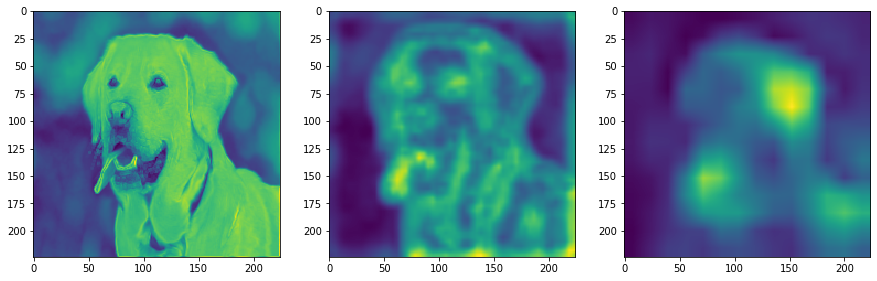

In [21]:
img = load_img('./images/dog0.jpg')
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(check_activation_map(vgg16_dog, "block1_conv1", img))

plt.subplot(1,3,2)
plt.imshow(check_activation_map(vgg16_dog, "block3_conv2", img))

plt.subplot(1,3,3)
plt.imshow(check_activation_map(vgg16_dog, "block5_conv3", img))

plt.show()

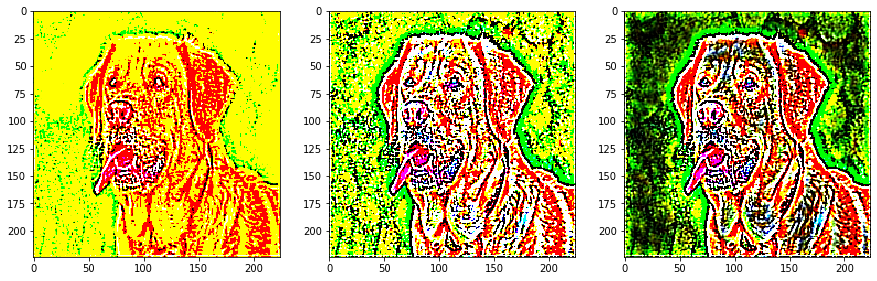

In [22]:
img = load_img('./images/dog0.jpg')
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(check_filtered_grad_img(vgg16_dog, "block1_conv1", img))

plt.subplot(1,3,2)
plt.imshow(check_filtered_grad_img(vgg16_dog, "block3_conv2", img))

plt.subplot(1,3,3)
plt.imshow(check_filtered_grad_img(vgg16_dog, "block5_conv3", img))

plt.show()

In [88]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data[0]

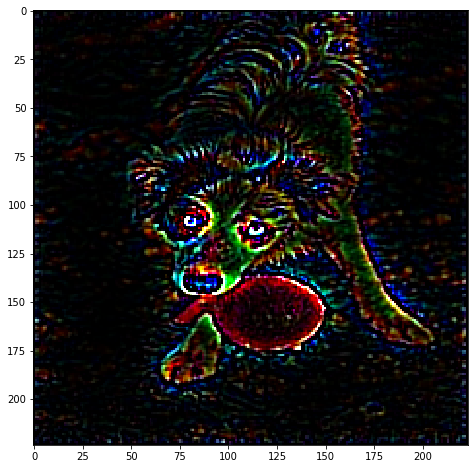

In [94]:
import copy
sample = get_one(valid)
grad_cam_image = generate_guide_backprop(vgg16_dog,sample[0][5], sample[1][5])*255
plt.figure(figsize=(8,8))
plt.imshow(grad_cam_image)
plt.show()

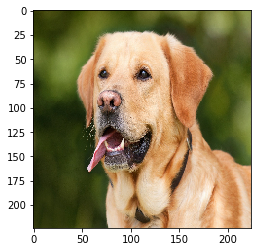

In [93]:
img = load_img('./images/dog0.jpg')
plt.imshow(img[0]/255)

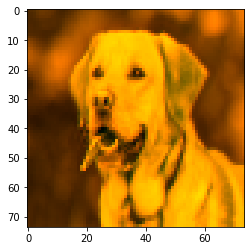

In [102]:
o = tf.keras.layers.Conv2D(3,3)(img)
o = tf.keras.layers.Conv2D(3,1)(o)
o = tf.keras.layers.AveragePooling2D(3)(o)
plt.imshow(o[0]/255)

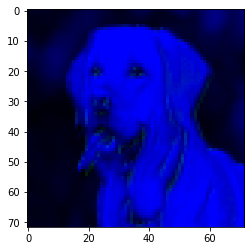

In [103]:
img = load_img('./images/dog0.jpg')
o = tf.keras.layers.AveragePooling2D(3)(img)
o = tf.keras.layers.Conv2D(3,1)(o)
o = tf.keras.layers.Conv2D(3,3)(o)
plt.imshow(o[0]/255)